# Projet numérique de Science des Données 2025

__Binôme numéro ### -- NOM 1 Prénom 1 et NOM 2 Prénom 2__

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

Cela leur permettrait d’obtenir un diagnostic facilement accessible, sans passer par une consultation potentiellement coûteuse. Dans le domaine de la santé, l’enjeu éthique est également très important : l’algorithme ayant en jeu des vies humaines, il est essentiel qu’il soit extrêmement fiable. Un algorithme est évidemment non objectif. D’un point de vue social, remplacer la main-d’œuvre qualifiée des professionnels de santé par un algorithme peut aussi être mal accepté. Psychologiquement, je pense que pour l’instant, aucune personne saine d’esprit n’accepterait tel quel un diagnostic médical issu d’un algorithme.

## Librairies usuelles

In [2]:
import pandas as pd
from sklearn import decomposition
from sklearn import preprocessing
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [3]:
df_train = pd.read_csv('donnees_entrainement.csv')

Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [4]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')

df_train.head()

,Age,Tension systolique,Tension diastolique,Glycémie,Température,FC au repos,Risque
0,21.0,85.0,55.0,7.0,36.2,84.0,1
1,36.0,145.0,100.0,6.9,39.5,73.0,2
2,15.5,120.0,75.0,7.4,39.0,74.0,0
3,49.0,135.0,100.0,15.9,37.8,72.0,1
4,56.5,120.0,90.0,12.0,36.9,74.0,1


# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

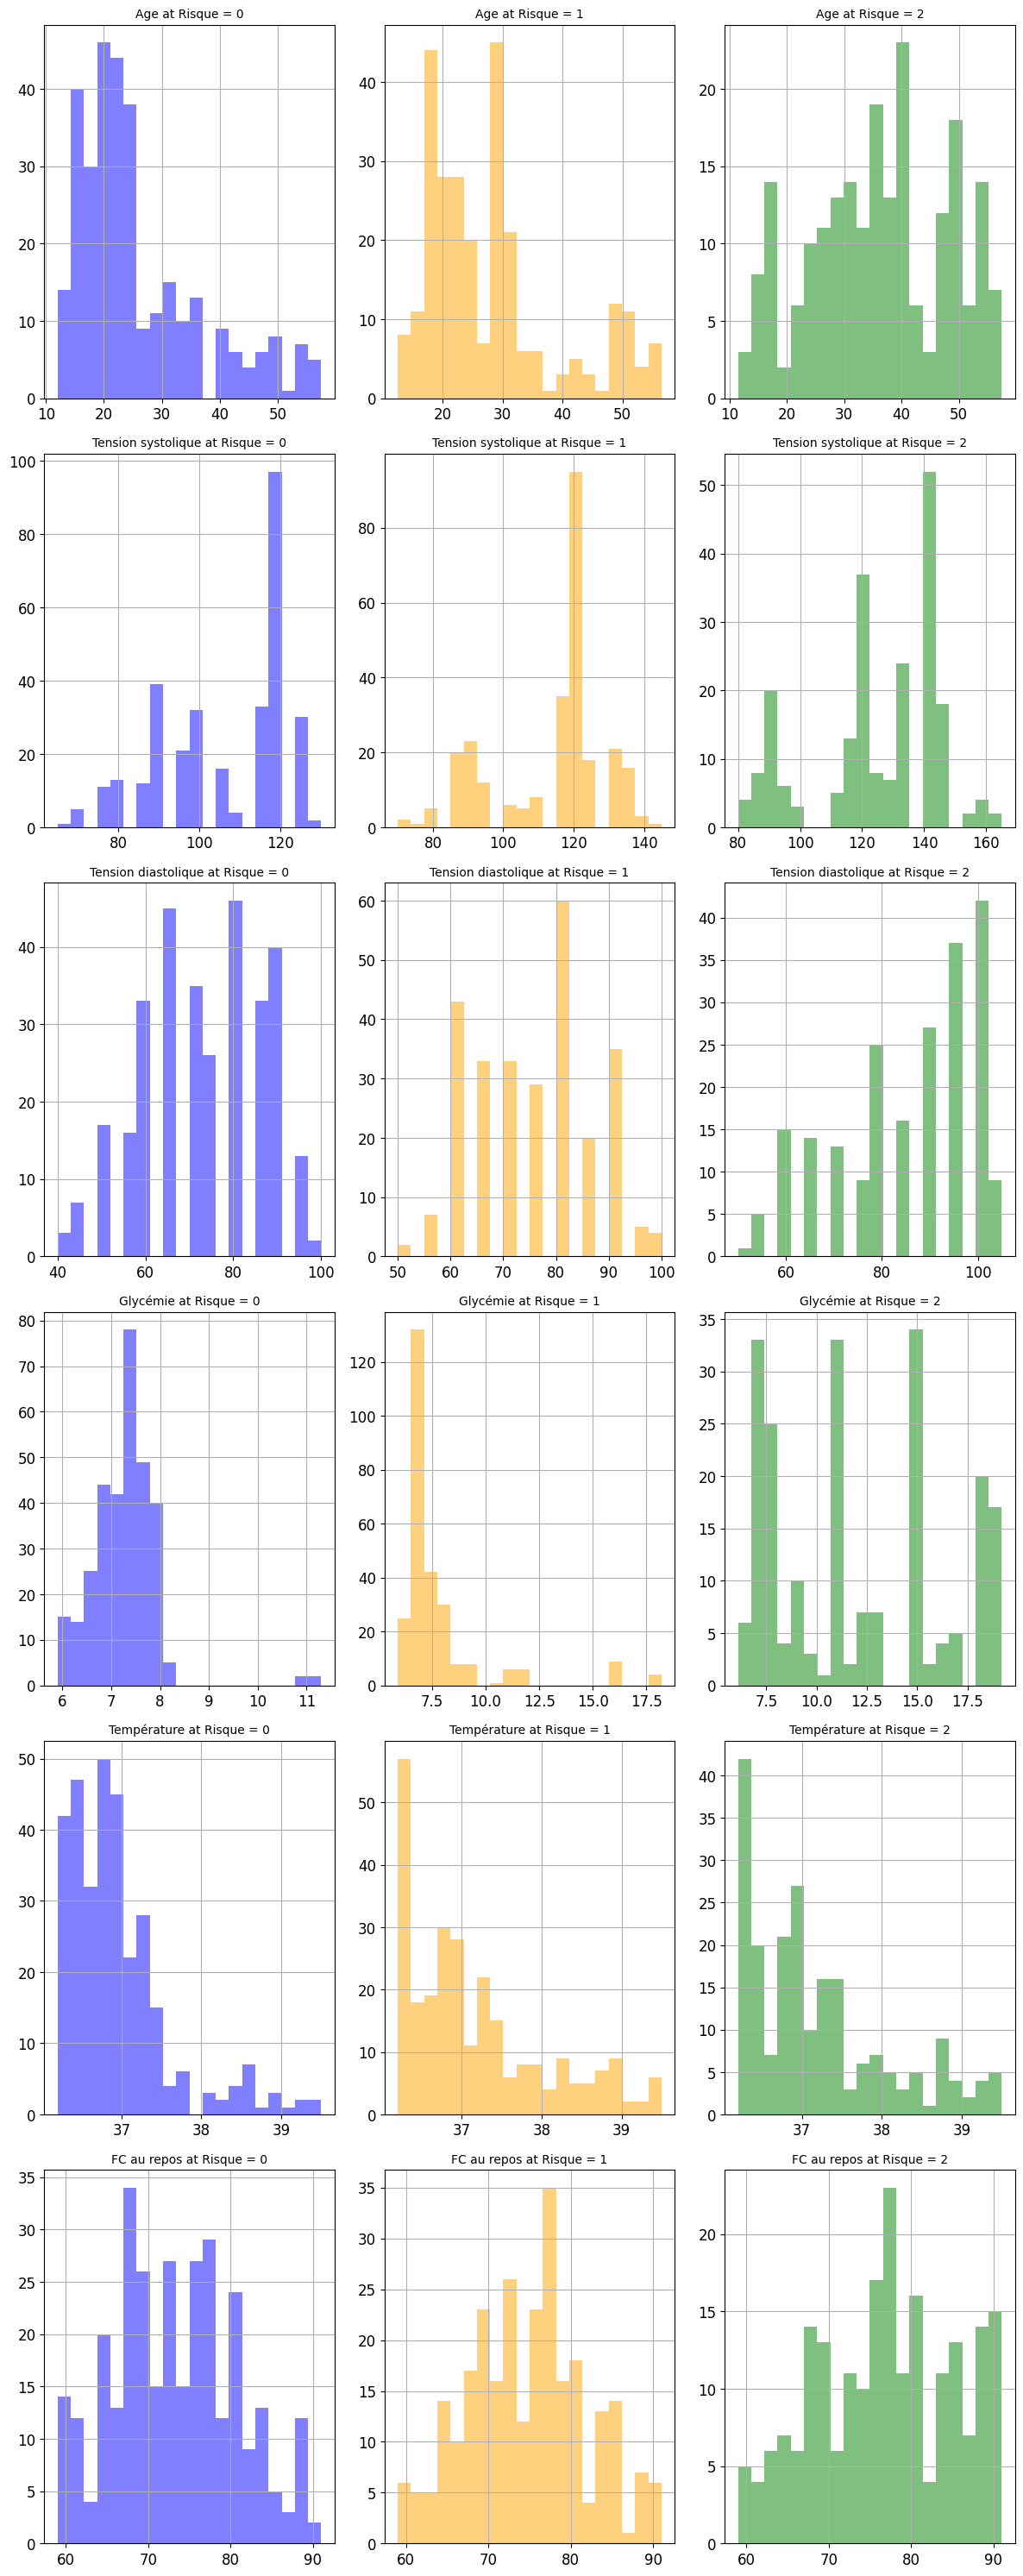

In [19]:
fig = plt.figure(figsize=(12, 30))
for i in range(3):
    masque = df_train['Risque'] == i
    df_f = df_train[masque]
    r=0
    for name in df_f.columns.drop('Risque'):
        ax = fig.add_subplot(6, 3, (3*r +i+1))
        color = 'blue' if i == 0 else 'orange' if i == 1 else 'green'
        h = ax.hist(df_f[name], bins=20, label=name + 'Risque = ' + str(i), color=color, alpha=0.5)
        ax.grid()
        ax.set_title(name +' at Risque = ' + str(i), fontsize=10)
        r+=1
fig.tight_layout(pad=1.0)

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

 -- Certaines variables ne présentent pas toutes de disparités quant au risque, cependant certaines clairement, comme la glycémie qui voit les femmes avec une forte glycémie être surtout à haut risque . La tension diastolique semble au contraire être un indicateur de risque faible, et la plupart des femmes à tension diastolique faible étaient à risque élevé . Il est entre autres cohérent que l'âge soit corrêlé au haut risque .

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

 -- Il semble y avoir assez de données, qui présentent suffisament de variance pour pouvoir distinguer les catégories et classifier avec efficacité des données de test .

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

(800, 2)


Text(0, 0.5, 'Compo 2')

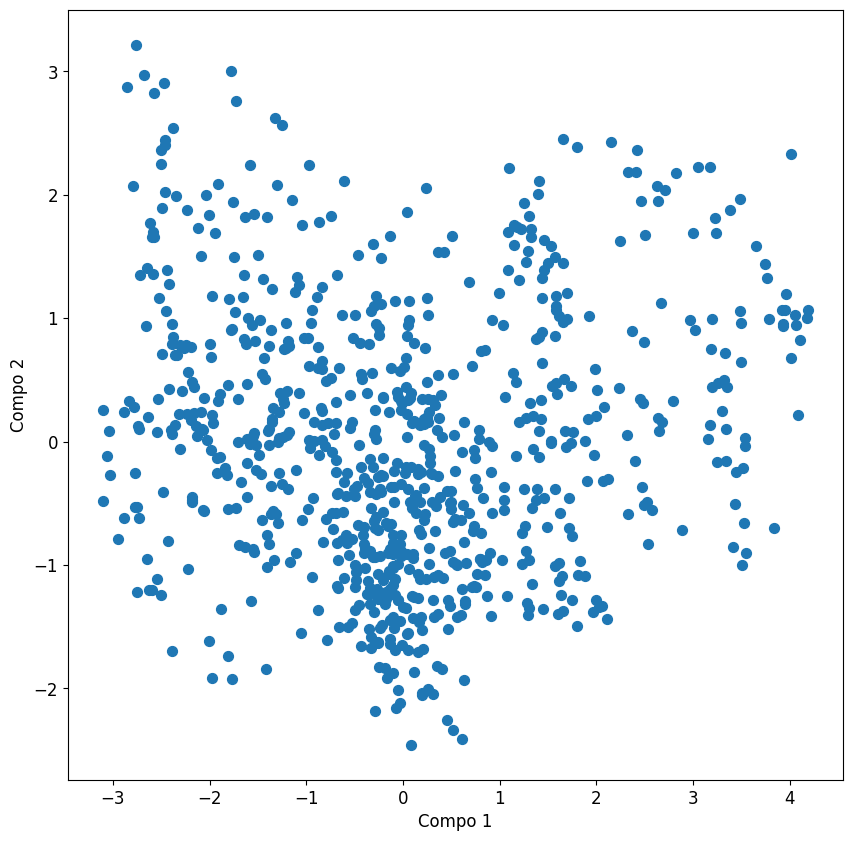

In [20]:
# Instanciation d'un objet PCA pour 2 composantes principales

std_scale = preprocessing.StandardScaler().fit(X_train)
X_scaled = std_scale.transform(X_train)

pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)
#Projection des données sur les 2 premières composantes principales
X_projected = pca.transform(X_scaled)
print(X_projected.shape)

fig = plt.figure(figsize=(10, 10)) # forcer une figure carrée


# Affichage des 2 premières composantes principales
plt.scatter(X_projected[:,0], X_projected[:,1], s=50)

plt.xlabel('Compo 1')
plt.ylabel('Compo 2')

### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

Text(0, 0.5, 'Proportion de variance expliquée')

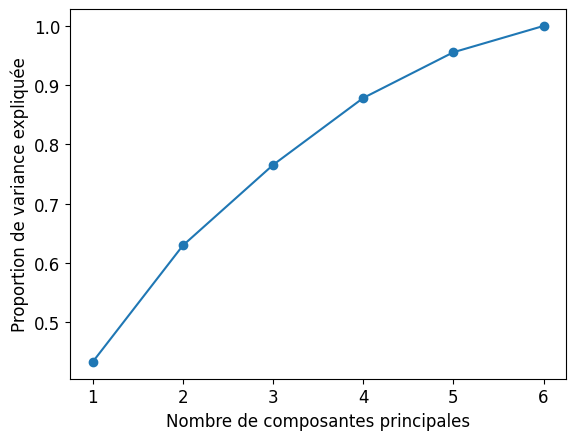

In [21]:
#on s'interesse quand meme une peu aux autres composantes principales
pca2 = decomposition.PCA(n_components=6)
pca2.fit(X_scaled)

plt.plot(np.arange(1, 7), pca2.explained_variance_ratio_.cumsum(), marker='o')

plt.xlabel("Nombre de composantes principales")
plt.ylabel("Proportion de variance expliquée")

 -- On explique ~65% de la variance avec ces deux premières composantes il me parait risqué d'essayer d'utiliser uniquement ces deux composantes pour faire nos prédictions . De plus, aucune composante n'explique moins de 5% de la variance , il serait dommage de perdre autant d'informations, mieux vaut faire une ACP .

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

Text(0.5, 1.0, 'Corrélation entre les 6 variables')

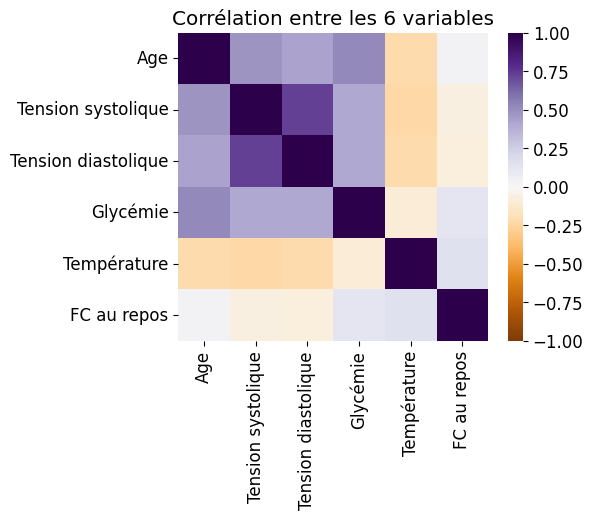

In [22]:
# Calcul de la matrice de corrélation deux à deux
corr_matrix = df_train.drop('Risque', axis=1).corr()

# Initialisation figure
plt.figure(figsize=(5, 4))

# Affichage heatmap
sns.heatmap(corr_matrix, 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )
# Titre
plt.title("Corrélation entre les 6 variables")

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

-- Lorsque deux variables sont largements corrélées ( plus de 0,9 disons), elles sont plus ou moins porteuses de la même information, et l'une d'entre elles est caduque .

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [9]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

In [10]:
TP = max(np.sum(y_train_risk_vs_norisk == 0), np.sum(y_train_risk_vs_norisk == 1))
accuracy = TP / len(y_train_risk_vs_norisk)
print(f"accuracy : {accuracy}")









accuracy : 0.605


### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

Par defaut un modèle qui prédit toujours la meme chose comme celui de la question 9 aurait un BA = 0.5 et la valeur ne serait pas sensible à la répartition de valeur vrai dans le jeu de donnée. Dans l'exemple du dessus si 90% des patient était à risque on aurait eu une accuracy encore meilleur de 90% mais le modèle est toujours aussi mauvais pour détecter les 10% restant alors que le BA resterait figé à 0.5;

dés que BA > 0.5 cela veut dire que le modéle arrive à bien identifier les deux catégories
Ba permet de s'intéresser à la performance sur les deux groupe à identifier

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

Enregistrer/mettre en mémoire les données d'entrainements

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

sur le jeu d'entrainement on s'attend à une précision équilibré de 1 puisque le plus proche voisin d'un point qui se trouve dans le jeu d'entrainement est lui meme

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score
X = np.array(df_train_risk_vs_norisk.drop(columns=['Risque']))
Y = np.array(df_train_risk_vs_norisk['Risque'])
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X, Y)



y_pred = neigh.predict(X)


print(f"BA = {balanced_accuracy_score(Y, y_pred)}")




BA = 1.0


### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

-- Mieux vaut centrer réduire les données d'entraînemet=nt, quitte à appliquer la même transformation aux données de test. Ne pas traiter préalablement les données pourrait mener à négliger de longues distances entre point suivant des axes à plus grande échelle comme la tension diastolique .

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

Meilleur k : 2
Meilleur BA : 0.7337528541536503


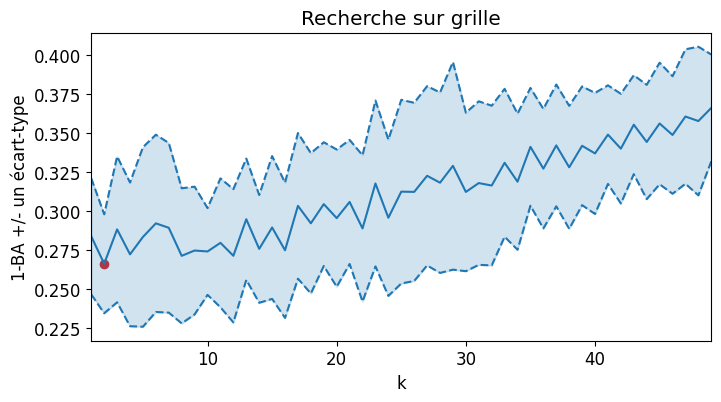

In [23]:
from sklearn import model_selection

kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=67)


# Définir la grille de valeurs de l'hyperparamètre k 
ks = np.arange(1, 50)

# Définir le modèle à évaluer
K = KNeighborsClassifier()

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(K, {'n_neighbors': ks}, 
                                    cv=kf, # on utilise les folds déjà définis
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid.fit(X, Y)

plt.figure(figsize=(8, 4))

erreur = 1-grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

plt.plot(grid.cv_results_['param_n_neighbors'], erreur, 
              color='tab:blue')
plt.plot(grid.cv_results_['param_n_neighbors'], erreur + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid.cv_results_['param_n_neighbors'], erreur - std_error, 
             color='tab:blue', linestyle='dashed')
plt.scatter(grid.best_params_['n_neighbors'], 1-grid.best_score_, 
           color='tab:red', label='k optimale')
# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(grid.cv_results_['param_n_neighbors'], (erreur + std_error), (erreur - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

# Mise en forme
plt.xlabel("k")
plt.ylabel("1-BA +/- un écart-type")
plt.xlim([ks[0], ks[-1]])
plt.title("Recherche sur grille")
print(f"Meilleur k : {grid.best_params_['n_neighbors']}")
print(f"Meilleur BA : {grid.best_score_}")

On prend une grille de k entier, on a 316 étiquettes  "sans risque" dans les données d'entrainement, le nombre de k plus proches voisins doit donc etre au moins inférieur à 316 dans le cas contraire par principe des tiroirs on aura la garantie d'avoir un voisin de la mauvaise étiquette parmi les k plus proches. On s'arrête à 50 voisins ce qui me parait suffisant pour tirer des conclusions. On a choisi la Balanced accuracy pour le scoring puisque c'est ce qui m'a paru suggéré par la question 10. On observe que par ailleurs que l'erreur croît lentement avec k mais sur des échelles de variation de k relativement grandes de l'ordre de 10 voisins. ainsi le maximum semble atteint pour k<15. Enfin je remarque que quasi systématiquement k=2 donne de meilleures performances que k = 1.

## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
Meilleur C : 3.4551072945922217
Meilleur BA : 0.6590105045237227


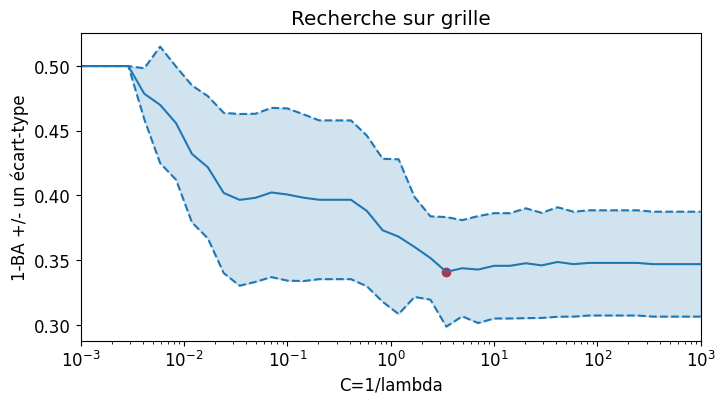

In [13]:
from sklearn import linear_model
# Définir la grille de valeurs de l'hyperparamètre alpha 
C = np.logspace(-3, 3, 40)

# Définir le modèle à tester
log = linear_model.LogisticRegression(penalty='l1',solver ='liblinear', max_iter=5000, )

# Instantier la recherche sur grille
gridlog = model_selection.GridSearchCV(log, {'C': C}, 
                                          cv=kf, 
                                          scoring='balanced_accuracy'
                                         )

gridlog.fit(X, Y)

plt.figure(figsize=(8, 4))

erreur = 1-gridlog.cv_results_['mean_test_score']
std_error = gridlog.cv_results_['std_test_score']
print(gridlog.cv_results_.keys())
plt.semilogx(gridlog.cv_results_['param_C'], erreur, 
              color='tab:blue')
plt.semilogx(gridlog.cv_results_['param_C'], erreur + std_error, 
             color='tab:blue', linestyle='dashed')
plt.semilogx(gridlog.cv_results_['param_C'], erreur - std_error, 
             color='tab:blue', linestyle='dashed')
plt.scatter(gridlog.best_params_['C'], 1-gridlog.best_score_, 
           color='tab:red', label='param_C optimale')
# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(gridlog.cv_results_['param_C'], (erreur + std_error), (erreur - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

# Mise en forme
plt.xlabel("C=1/lambda")
plt.ylabel("1-BA +/- un écart-type")
plt.xlim([C[0], C[-1]])
plt.title("Recherche sur grille")
print(f"Meilleur C : {gridlog.best_params_['C']}")
print(f"Meilleur BA : {gridlog.best_score_}")

j'ai pris une régularisation l1 ("lasso") car elle permet d'avoir plus de coef de regression nul ce qui évite le sur apprentissage, cela demande un solveur specifique qui est assez lent. On obtient des meilleurs score avec une régularisation faible (C important). Avec une régularisation de ridge j'obtiens des resultat similaires donc le temps de calcul supplémentaire n'est pas utile. Etonnament on obtient des BA  moins bon qu'avec les k plus proche voisins, bien que ce propos est à nuancé par l'écart type énorme qui permet en réalité aucune comparaison significatives entre les performances des deux modèles.

## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

In [ ]:


kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=67)


# Définir la grille de valeurs de l'hyperparamètre k 
ks = np.arange(1, 50)

# Définir le modèle à évaluer
K = KNeighborsClassifier()

# Instantier la recherche sur grille
grid = model_selection.GridSearchCV(K, {'n_neighbors': ks}, 
                                    cv=kf, # on utilise les folds déjà définis
                                    scoring='balanced_accuracy'
                                   )

# Utiliser la recherche sur grille
grid.fit(X, Y)

plt.figure(figsize=(8, 4))

erreur = 1-grid.cv_results_['mean_test_score']
std_error = grid.cv_results_['std_test_score']

plt.plot(grid.cv_results_['param_n_neighbors'], erreur, 
              color='tab:blue')
plt.plot(grid.cv_results_['param_n_neighbors'], erreur + std_error, 
             color='tab:blue', linestyle='dashed')
plt.plot(grid.cv_results_['param_n_neighbors'], erreur - std_error, 
             color='tab:blue', linestyle='dashed')
plt.scatter(grid.best_params_['n_neighbors'], 1-grid.best_score_, 
           color='tab:red', label='k optimale')
# colorer l'espace entre les courbes représentant les écarts-types
plt.fill_between(grid.cv_results_['param_n_neighbors'], (erreur + std_error), (erreur - std_error), 
                 color='tab:blue',
                 alpha=0.2, # contrôle la transparence
                )

# Mise en forme
plt.xlabel("k")
plt.ylabel("1-BA +/- un écart-type")
plt.xlim([ks[0], ks[-1]])
plt.title("Recherche sur grille")
print(f"Meilleur k : {grid.best_params_['n_neighbors']}")
print(f"Meilleur BA : {grid.best_score_}")

## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.